## Setup and Imports

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

# เพิ่ม path ให้ Python มองเห็น folder src
sys.path.append('..')

from src.config import config
from src.utils import seed_everything
from src.dataset import HAM10000Dataset, get_weighted_dataloader
from src.transforms import get_transforms  # <--- บรรทัดนี้สำคัญมาก! ที่ Error เพราะขาดอันนี้
from src.models import get_model
from src.train import train_model

# Lock Seed
seed_everything(config.SEED)

print(f"  Device: {config.DEVICE}")
print(f"  Config: {config.BASE_MODEL.upper()} | CBAM: {config.USE_CBAM}")
print(f"  Strategy: {config.LOSS_TYPE.upper()} Loss + Heavy Augmentation")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Global seed set to 42
  Device: mps
  Config: RESNET50_CBAM_TUNED | CBAM: True
  Strategy: FOCAL Loss + Heavy Augmentation


## Data Preparation

In [3]:
# 1. Define Transforms
# Train: ใช้ Dictionary เพื่อแยก Light/Heavy Augmentation
train_transforms = get_transforms(split='train')
# Val: ใช้ Standard Resize + Normalize
val_transforms = get_transforms(split='val')

# 2. Create Datasets
train_ds = HAM10000Dataset(config.PROCESSED_DATA_DIR / 'train.csv', transform=train_transforms)
val_ds = HAM10000Dataset(config.PROCESSED_DATA_DIR / 'val.csv', transform=val_transforms)

print(f"Train set: {len(train_ds)} images")
print(f"Val set:   {len(val_ds)} images")

# 3. Create DataLoaders
# Mac M-series: แนะนำ num_workers=0 (ชัวร์สุด) หรือ 2
# Windows/Linux GPU: ปรับเป็น 4 ได้เลย
BATCH_SIZE = config.BATCH_SIZE
NUM_WORKERS = config.NUM_WORKERS # หรือ hardcode เป็น 0 ถ้าเจอ error

print("Creating Weighted Train Loader...")
train_loader = get_weighted_dataloader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    num_workers=0 # Mac แนะนำ 0 เพื่อความชัวร์
)

val_loader = DataLoader(
    val_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("DataLoaders ready!")

 Augmentation Strategy: CLASS-SPECIFIC (Light/Heavy for Proposed)
Train set: 7054 images
Val set:   1464 images
Creating Weighted Train Loader...
DataLoaders ready!


## Pre-Training Check

In [4]:
# ลองดู Distribution ของข้อมูล Train
train_df = pd.read_csv(config.PROCESSED_DATA_DIR / 'train.csv')
class_counts = train_df['dx'].value_counts()
print("Class Distribution in Training Set:")
print(class_counts)

# (Optional) คำนวณ Weight เล่นๆ ดูว่า NV จะโดนลดความสำคัญขนาดไหน
total = len(train_df)
weights = total / (len(class_counts) * class_counts)
print("\n Estimated Class Weights (Inverse Frequency):")
print(weights.sort_values())

Class Distribution in Training Set:
dx
nv       4730
mel       777
bkl       775
bcc       365
akiec     233
vasc       98
df         76
Name: count, dtype: int64

 Estimated Class Weights (Inverse Frequency):
dx
nv        0.213047
mel       1.296930
bkl       1.300276
bcc       2.760861
akiec     4.324954
vasc     10.282799
df       13.259398
Name: count, dtype: float64


## Initialize Model

In [5]:
# สร้าง Model (ResNet50+CBAM หรือ EfficientNet ตาม Config)
model = get_model(device=config.DEVICE)

print(f"Model created on {config.DEVICE}")

 Building Model: ResNet50 | CBAM=True
Model created on mps


## Training

In [6]:
print("Starting Training Loop...")

# เรียกฟังก์ชัน train_model จาก src/train.py
# ฟังก์ชันนี้จะจัดการเรื่อง Loss, Optimizer, Class Weights ให้เองข้างใน
trained_model, history = train_model(
    model, 
    train_loader, 
    val_loader, 
    device=config.DEVICE
)

print("Training Finished!")

Starting Training Loop...
⚖️  Calculating class weights from training set...
Class Weights: [ 4.32  2.76  1.3  13.26  1.3   0.21 10.28]
 Using Focal Loss (gamma=2.0) WITHOUT Class Weights
 Start Training for 50 epochs...


Evaluating:   0%|                                        | 0/46 [00:00<?, ?it/s]/Users/mati/adv_skin_cancer/skin_venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|███████████████████████████████| 46/46 [00:15<00:00,  4.02it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 1/50 | Time: 264s | LR: 1.0e-04
  Train Loss: 1.3007 Acc: 0.2272
  Val   Loss: 0.8741 Acc: 0.6045  Saved (Val Loss: 0.8741)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:17<00:00,  3.59it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 2/50 | Time: 278s | LR: 1.0e-04
  Train Loss: 0.9028 Acc: 0.4549
  Val   Loss: 0.5856 Acc: 0.6892  Saved (Val Loss: 0.5856)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:17<00:00,  3.74it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 3/50 | Time: 283s | LR: 1.0e-04
  Train Loss: 0.4653 Acc: 0.6744
  Val   Loss: 0.4892 Acc: 0.6967  Saved (Val Loss: 0.4892)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:17<00:00,  3.69it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 4/50 | Time: 281s | LR: 1.0e-04
  Train Loss: 0.3138 Acc: 0.7661
  Val   Loss: 0.4605 Acc: 0.7199  Saved (Val Loss: 0.4605)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:17<00:00,  3.62it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 5/50 | Time: 279s | LR: 1.0e-04
  Train Loss: 0.2426 Acc: 0.8049
  Val   Loss: 0.2933 Acc: 0.7917  Saved (Val Loss: 0.2933)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:17<00:00,  3.81it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 6/50 | Time: 277s | LR: 1.0e-04
  Train Loss: 0.2021 Acc: 0.8394
  Val   Loss: 0.2859 Acc: 0.7930  Saved (Val Loss: 0.2859)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:16<00:00,  3.86it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 7/50 | Time: 271s | LR: 1.0e-04
  Train Loss: 0.1681 Acc: 0.8615
  Val   Loss: 0.2790 Acc: 0.7951  Saved (Val Loss: 0.2790)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:16<00:00,  3.82it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 8/50 | Time: 280s | LR: 1.0e-04
  Train Loss: 0.1424 Acc: 0.8747
  Val   Loss: 0.2790 Acc: 0.8053  Saved (Val Loss: 0.2790)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:17<00:00,  3.81it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 9/50 | Time: 271s | LR: 1.0e-04
  Train Loss: 0.1136 Acc: 0.9059
  Val   Loss: 0.3248 Acc: 0.7910 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:17<00:00,  3.87it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 10/50 | Time: 270s | LR: 1.0e-04
  Train Loss: 0.1167 Acc: 0.8968
  Val   Loss: 0.2810 Acc: 0.8060 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:17<00:00,  3.88it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 11/50 | Time: 267s | LR: 1.0e-04
  Train Loss: 0.1048 Acc: 0.9033
  Val   Loss: 0.2711 Acc: 0.8245  Saved (Val Loss: 0.2711)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:16<00:00,  4.15it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 12/50 | Time: 265s | LR: 1.0e-04
  Train Loss: 0.0839 Acc: 0.9192
  Val   Loss: 0.2556 Acc: 0.8115  Saved (Val Loss: 0.2556)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:16<00:00,  4.00it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 13/50 | Time: 267s | LR: 1.0e-04
  Train Loss: 0.0714 Acc: 0.9291
  Val   Loss: 0.2501 Acc: 0.8122  Saved (Val Loss: 0.2501)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:16<00:00,  3.88it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 14/50 | Time: 270s | LR: 1.0e-04
  Train Loss: 0.0683 Acc: 0.9311
  Val   Loss: 0.2668 Acc: 0.7896 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:16<00:00,  3.90it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 15/50 | Time: 272s | LR: 1.0e-04
  Train Loss: 0.0692 Acc: 0.9349
  Val   Loss: 0.2606 Acc: 0.8190 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:17<00:00,  3.88it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 16/50 | Time: 270s | LR: 1.0e-04
  Train Loss: 0.0669 Acc: 0.9327
  Val   Loss: 0.2711 Acc: 0.8286 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:17<00:00,  3.71it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 17/50 | Time: 272s | LR: 1.0e-04
  Train Loss: 0.0555 Acc: 0.9451
  Val   Loss: 0.2716 Acc: 0.8265 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:17<00:00,  3.75it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 18/50 | Time: 276s | LR: 1.0e-05
  Train Loss: 0.0431 Acc: 0.9595
  Val   Loss: 0.2499 Acc: 0.8299  Saved (Val Loss: 0.2499)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:17<00:00,  3.74it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 19/50 | Time: 276s | LR: 1.0e-05
  Train Loss: 0.0359 Acc: 0.9637
  Val   Loss: 0.2498 Acc: 0.8367  Saved (Val Loss: 0.2498)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:16<00:00,  3.86it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 20/50 | Time: 277s | LR: 1.0e-05
  Train Loss: 0.0305 Acc: 0.9665
  Val   Loss: 0.2502 Acc: 0.8340 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:18<00:00,  3.66it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 21/50 | Time: 280s | LR: 1.0e-05
  Train Loss: 0.0278 Acc: 0.9673
  Val   Loss: 0.2516 Acc: 0.8286 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:18<00:00,  3.61it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 22/50 | Time: 288s | LR: 1.0e-05
  Train Loss: 0.0245 Acc: 0.9733
  Val   Loss: 0.2508 Acc: 0.8354 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:18<00:00,  3.54it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 23/50 | Time: 291s | LR: 1.0e-05
  Train Loss: 0.0270 Acc: 0.9704
  Val   Loss: 0.2442 Acc: 0.8388  Saved (Val Loss: 0.2442)
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:19<00:00,  2.97it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 24/50 | Time: 302s | LR: 1.0e-05
  Train Loss: 0.0231 Acc: 0.9760
  Val   Loss: 0.2534 Acc: 0.8333 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:19<00:00,  3.03it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 25/50 | Time: 296s | LR: 1.0e-05
  Train Loss: 0.0260 Acc: 0.9728
  Val   Loss: 0.2627 Acc: 0.8327 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:18<00:00,  3.41it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 26/50 | Time: 302s | LR: 1.0e-05
  Train Loss: 0.0191 Acc: 0.9777
  Val   Loss: 0.2522 Acc: 0.8333 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:24<00:00,  2.65it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 27/50 | Time: 307s | LR: 1.0e-05
  Train Loss: 0.0206 Acc: 0.9790
  Val   Loss: 0.2666 Acc: 0.8265 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:20<00:00,  3.23it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 28/50 | Time: 322s | LR: 1.0e-06
  Train Loss: 0.0194 Acc: 0.9793
  Val   Loss: 0.2612 Acc: 0.8340 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:22<00:00,  3.13it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 29/50 | Time: 334s | LR: 1.0e-06
  Train Loss: 0.0186 Acc: 0.9800
  Val   Loss: 0.2694 Acc: 0.8388 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:20<00:00,  3.15it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 30/50 | Time: 326s | LR: 1.0e-06
  Train Loss: 0.0193 Acc: 0.9792
  Val   Loss: 0.2638 Acc: 0.8395 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:20<00:00,  3.18it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 31/50 | Time: 330s | LR: 1.0e-06
  Train Loss: 0.0183 Acc: 0.9779
  Val   Loss: 0.2656 Acc: 0.8422 
----------------------------------------


Evaluating: 100%|███████████████████████████████| 46/46 [00:21<00:00,  3.11it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Epoch 32/50 | Time: 333s | LR: 1.0e-07
  Train Loss: 0.0182 Acc: 0.9793
  Val   Loss: 0.2676 Acc: 0.8367 
----------------------------------------
 Early stopping triggered (Low LR)
 Training Complete. Best Val Loss: 0.2442
Training Finished!


## Visualization 

Saved history to: /Users/mati/adv_skin_cancer/reports/metrics/history_resnet50_cbam_tuned.csv
Saved plot to: /Users/mati/adv_skin_cancer/reports/figures/learning_curve_resnet50_cbam_tuned.png


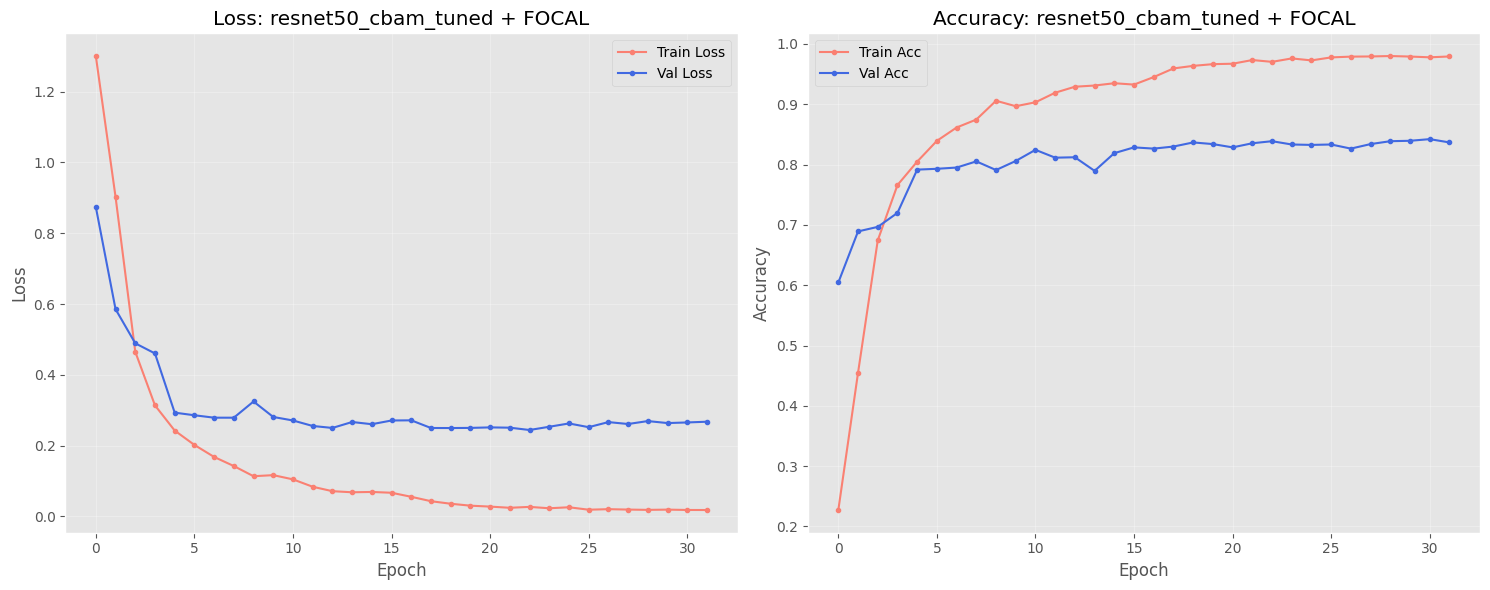

In [7]:
# 1. Convert History to DataFrame
hist_df = pd.DataFrame(history)

# 2. Save CSV (เผื่อเอาไป plot ใหม่สวยๆ ใน Excel/Tableau)
hist_path = config.METRIC_DIR / f'history_{config.BASE_MODEL}.csv'
hist_df.to_csv(hist_path, index=False)
print(f"Saved history to: {hist_path}")

# 3. Plotting
plt.style.use('ggplot') # เลือกธีมกราฟให้ดู Pro ขึ้น
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loss Curve
ax1.plot(hist_df['train_loss'], label='Train Loss', marker='.', color='salmon')
ax1.plot(hist_df['val_loss'], label='Val Loss', marker='.', color='royalblue')
ax1.set_title(f'Loss: {config.BASE_MODEL} + {config.LOSS_TYPE.upper()}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy Curve
ax2.plot(hist_df['train_acc'], label='Train Acc', marker='.', color='salmon')
ax2.plot(hist_df['val_acc'], label='Val Acc', marker='.', color='royalblue')
ax2.set_title(f'Accuracy: {config.BASE_MODEL} + {config.LOSS_TYPE.upper()}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save Image
fig_path = config.FIGURE_DIR / f'learning_curve_{config.BASE_MODEL}.png'
plt.savefig(fig_path, dpi=300) # Save ชัดๆ (300 DPI)
print(f"Saved plot to: {fig_path}")

plt.show()